In [1]:
import pandas as pd
import numpy as np

In [2]:
from collections import defaultdict
from spacy.util import minibatch
from spacy.util import compounding
import spacy
import os
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter
import plotly.figure_factory as ff
import plotly.express as px
from plotly import graph_objs as go
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]


In [4]:
import plotly.io as pio
pio.renderers


Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [5]:
pio.renderers.default = "notebook_connected"


In [6]:
!ls /fp/projects01/ec307/ec-krimhau/jira_datasets

highest_high_vs_low_lowest_balanced_jira.csv	high_highest_vs_rest
highest_vs_lowest_balanced_jira.csv		high_vs_rest
highest_vs_rest_min_len_25th_balanced_jira.csv	jira_clean_with_all_cols.csv


In [7]:
file_name = "jira_clean_with_all_cols.csv"
path_name = "/fp/projects01/ec307/ec-krimhau/jira_datasets"
full_name = f"{path_name}/{file_name}"

In [8]:
df = pd.read_csv(full_name, index_col=0)
df

,description,project,labels,issuetype,collection,class,text_str,text_clean
priority,,,,,,,,
Blocker,We tried upgrading from Spring Boot 2.0.6 to S...,Spring XD,[],Bug,Spring,Highest,We tried upgrading from Spring Boot 2.0.6 to S...,we tried upgrading from spring boot to spring ...
Major,The jobs that appear under Executions section ...,Spring XD,[],Bug,Spring,Medium,The jobs that appear under Executions section ...,the jobs that appear under executions section ...
Trivial,Working with Spring-XD version 1.3.2.RELEASE\n...,Spring XD,[],Bug,Spring,Lowest,Working with Spring-XD version 1.3.2.RELEASE\n...,working with springxd version the server with ...
Major,My project 7 node cluster and in that 2 node a...,Spring XD,"['Spring', 'xd']",Bug,Spring,Medium,My project 7 node cluster and in that 2 node a...,my project node cluster and in that node are a...
Minor,See https://github.com/spring-projects/spring-...,Spring XD,[],Story,Spring,Low,See https://github.com/spring-projects/spring-...,NaN
...,...,...,...,...,...,...,...,...
Major,it is very beautiful.,Community Support - Open Source Project Reposi...,[],New Project,Sonatype,Medium,it is very beautiful.,it is very beautiful
Major,library,Community Support - Open Source Project Reposi...,[],New Project,Sonatype,Medium,library,NaN
Major,What is reactive-gremlin\r\n\r\nreactive-greml...,Community Support - Open Source Project Reposi...,[],New Project,Sonatype,Medium,What is reactive-gremlin\r\n\r\nreactive-greml...,what is reactivegremlin reactivegremlin is a s...


In [9]:
df = df.drop(columns=['description', 'text_str', 'labels'])
df

,project,issuetype,collection,class,text_clean
priority,,,,,
Blocker,Spring XD,Bug,Spring,Highest,we tried upgrading from spring boot to spring ...
Major,Spring XD,Bug,Spring,Medium,the jobs that appear under executions section ...
Trivial,Spring XD,Bug,Spring,Lowest,working with springxd version the server with ...
Major,Spring XD,Bug,Spring,Medium,my project node cluster and in that node are a...
Minor,Spring XD,Story,Spring,Low,NaN
...,...,...,...,...,...
Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,it is very beautiful
Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,NaN
Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,what is reactivegremlin reactivegremlin is a s...


In [10]:
df = df.rename(columns={'text_clean': 'text'})

In [11]:
# Drop NaN values and reset index of dataframe
df = df[df['text'].notna()]
df = df.reset_index()

In [12]:
df


,priority,project,issuetype,collection,class,text
0,Blocker,Spring XD,Bug,Spring,Highest,we tried upgrading from spring boot to spring ...
1,Major,Spring XD,Bug,Spring,Medium,the jobs that appear under executions section ...
2,Trivial,Spring XD,Bug,Spring,Lowest,working with springxd version the server with ...
3,Major,Spring XD,Bug,Spring,Medium,my project node cluster and in that node are a...
4,Major,Spring XD,Bug,Spring,Medium,im trying to run a job on springxd and the job...
...,...,...,...,...,...,...
1369976,Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,simple android lib for pushing little messages...
1369977,Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,it is very beautiful
1369978,Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,what is reactivegremlin reactivegremlin is a s...
1369979,Major,Community Support - Open Source Project Reposi...,New Project,Sonatype,Medium,android view for a swipeable weekly calendar


In [13]:
df["class"].value_counts()

class
Medium     933029
Low        267697
High        81404
Highest     55358
Lowest      32493
Name: count, dtype: int64

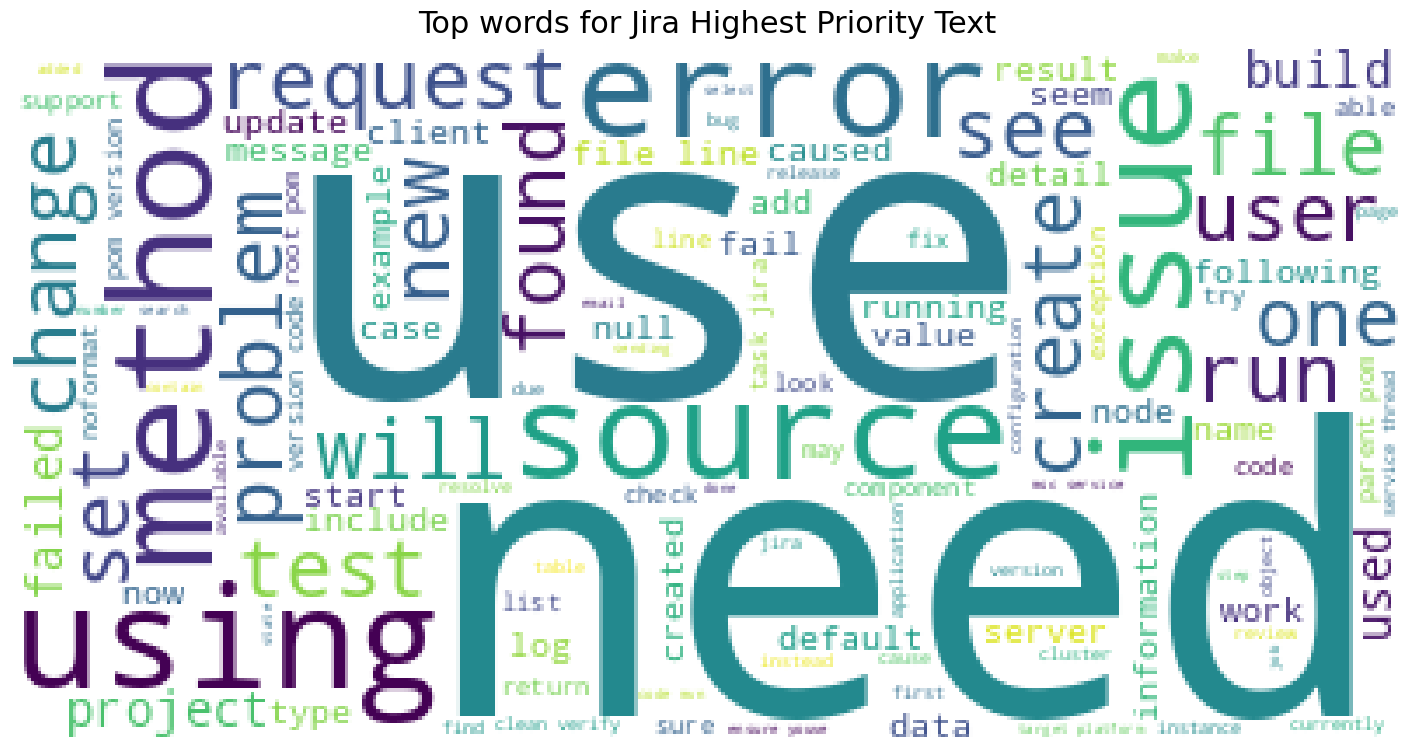

In [14]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in df.loc[df['class'] == "Highest", 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for Jira Highest Priority Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


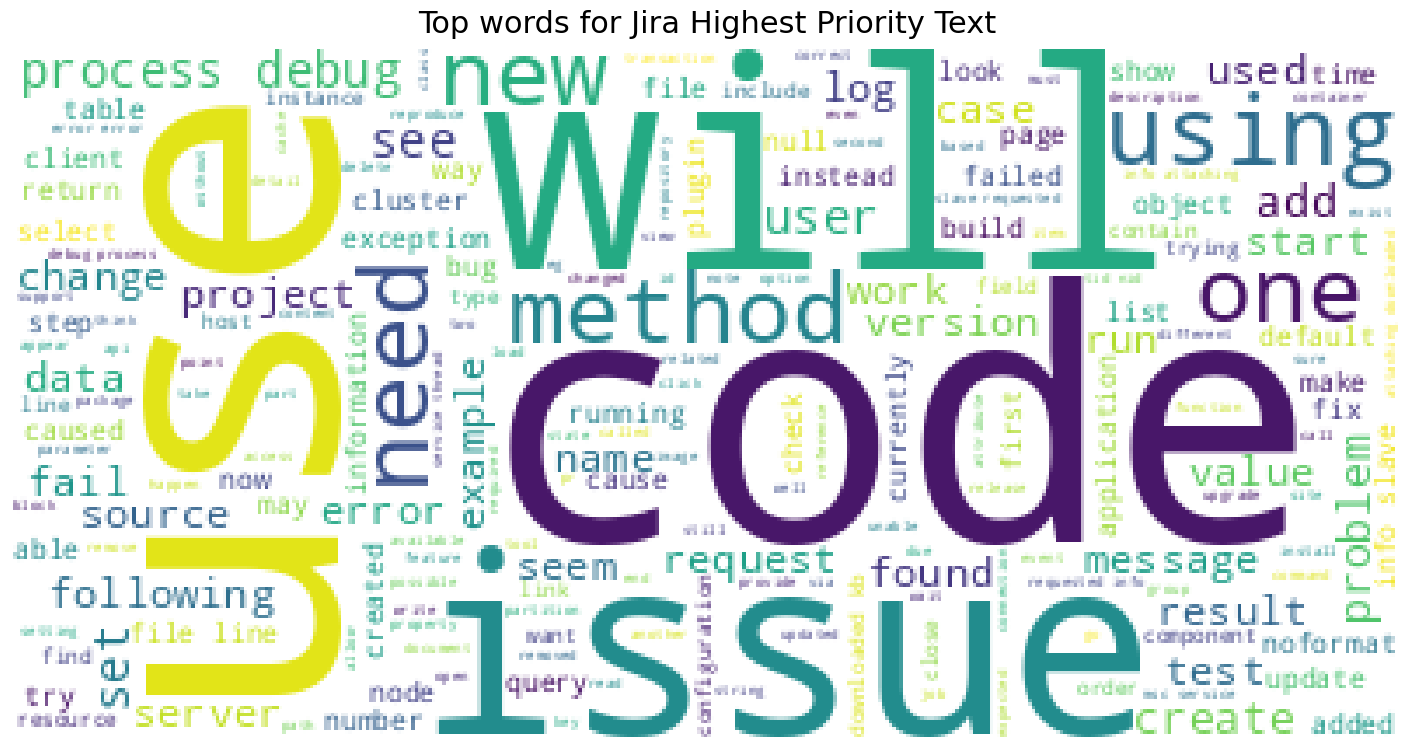

In [15]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in df.loc[df['class'] == "High", 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for Jira High Priority Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

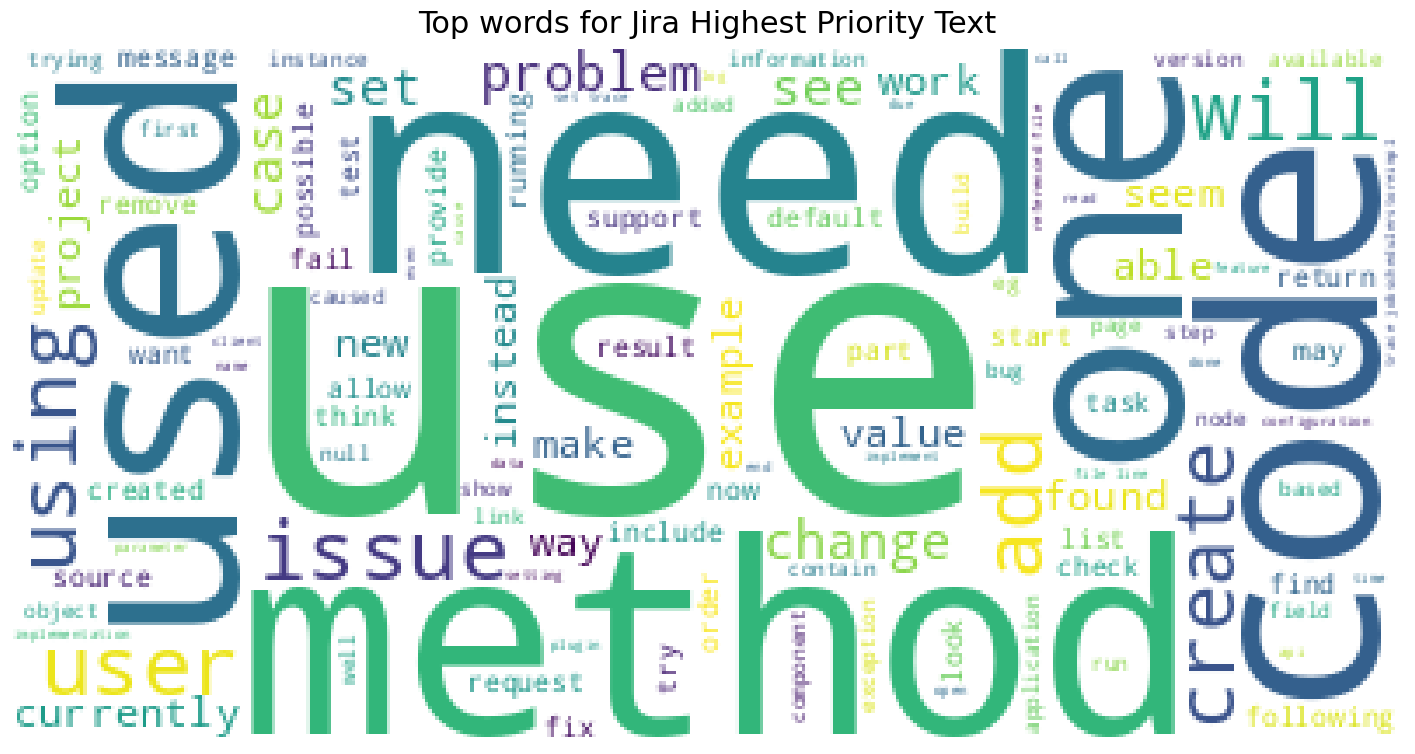

In [16]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in df.loc[df['class'] == "Medium", 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for Jira Medium Priority Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

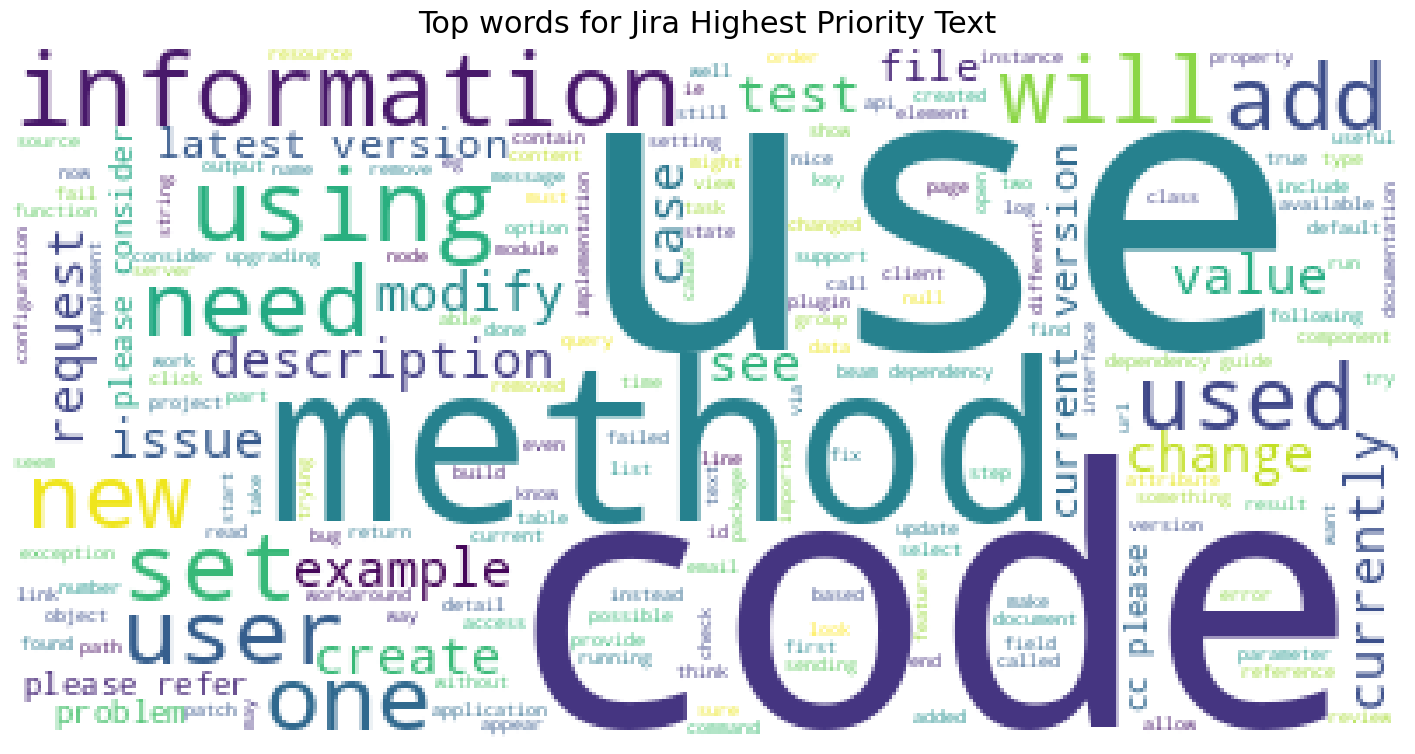

In [17]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in df.loc[df['class'] == "Low", 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for Jira Low Priority Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

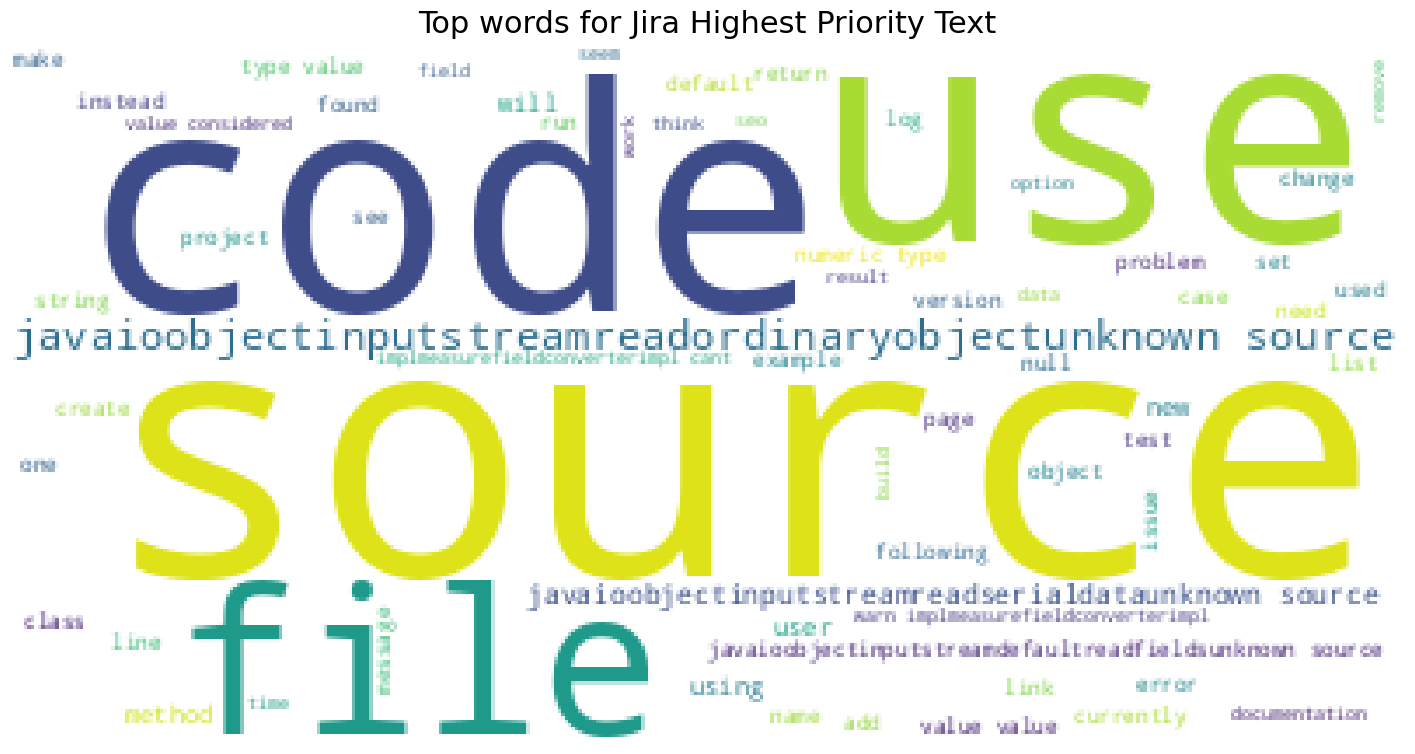

In [18]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in df.loc[df['class'] == "Lowest", 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for Jira Lowest Priority Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [19]:
top_debt_words = wc.generate(
    ' '.join(text for text in df.loc[df['class'] == 'Highest', 'text']))


In [20]:
top_debt_words.words_

{'use': 1.0,
 'need': 0.9013474494706448,
 'using': 0.8823387872954764,
 'method': 0.8718719923002888,
 'error': 0.8125601539942252,
 'issue': 0.7982435033686237,
 'source': 0.7823628488931665,
 'request': 0.7601058710298364,
 'will': 0.7022377285851781,
 'file': 0.6935755534167469,
 'one': 0.6797401347449471,
 'new': 0.6717998075072185,
 'test': 0.6657844080846969,
 'see': 0.6607314725697786,
 'problem': 0.6430461982675649,
 'user': 0.6351058710298364,
 'change': 0.6079162656400385,
 'create': 0.5955245428296438,
 'run': 0.5895091434071222,
 'set': 0.5856592877767084,
 'found': 0.585298363811357,
 'project': 0.5809672762271415,
 'failed': 0.5412656400384985,
 'build': 0.5354908565928778,
 'used': 0.519730510105871,
 'following': 0.5018046198267565,
 'fail': 0.4916987487969201,
 'server': 0.48411934552454283,
 'caused': 0.4672762271414822,
 'add': 0.4625842155919153,
 'start': 0.4409287776708373,
 'work': 0.43948508180943213,
 'file line': 0.4391241578440808,
 'update': 0.4310635226179

In [ ]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()


In [ ]:
# Assuming 'text_len' is already calculated as shown previously
description = df['text_len'].describe()

# Applying formatting to make numbers more readable
formatted_description = description.apply(lambda x: f"{x:,.0f}")
print(formatted_description)

In [ ]:
df['text_len'].describe()

In [ ]:
balance_counts = df.groupby('class')['class'].agg('count').values
balance_counts


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Non-TD'],
    y=[balance_counts[0]],
    name='Non-TD',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['TD'],
    y=[balance_counts[1]],
    name='TD',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by label</span>'
)
fig.show()


In [ ]:
Non_JIRA_df = JIRA_df[JIRA_df['label'] == 0]['text_len'].value_counts().sort_index()
JIRA_df1 = JIRA_df[JIRA_df['label'] == 1]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Non_JIRA_df.index,
    y=Non_JIRA_df.values,
    name='Non_TD',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=JIRA_df1.index,
    y=JIRA_df1.values,
    name='TD',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Message length</span>'
)
fig.update_xaxes(range=[0, 300])
fig.show()


In [ ]:
from nltk.util import ngrams
from plotly import tools
import plotly.offline as py


In [ ]:
#Gram analysis on Training set- Bigram and Trigram
stopword = set(stopwords.words('english'))


def gram_analysis(data, gram):
    tokens = [t for t in data.lower().split(
        " ") if t != "" if t not in stopword]
    ngrams = zip(*[tokens[i:] for i in range(gram)])
    final_tokens = [" ".join(z) for z in ngrams]
    return final_tokens


#Create frequency grams for analysis

def create_dict(data, grams):
    freq_dict = defaultdict(int)
    for sentence in data:
        for tokens in gram_analysis(sentence, grams):
            freq_dict[tokens] += 1
    return freq_dict


def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["n_gram_words"].values[::-1],
        x=df["n_gram_frequency"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace


def create_new_df(freq_dict,):
    freq_df = pd.DataFrame(sorted(freq_dict.items(), key=lambda z: z[1])[::-1])
    freq_df.columns = ['n_gram_words', 'n_gram_frequency']
   
    trace = horizontal_bar_chart(freq_df[:20], 'orange')
    return trace


def plot_grams(trace_zero, trace_one):
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of Non_TD ",
                                              "Frequent words of TD"])
    fig.append_trace(trace_zero, 1, 1)
    fig.append_trace(trace_ones, 1, 2)
    fig['layout'].update(height=1200, width=900,
                         paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')


In [ ]:
JIRA_df_zero = JIRA_df[JIRA_df['label'] == 0]
JIRA_df_ones= JIRA_df[JIRA_df['label'] == 1]

In [ ]:
print("Bi-gram analysis")
freq_df_zero=create_dict(JIRA_df_zero["text"],2)

In [ ]:
trace_zero = create_new_df(freq_df_zero)
freq_df_ones = create_dict(JIRA_df_ones["text"], 2)
trace_ones = create_new_df(freq_df_ones)


In [ ]:
plot_grams(trace_zero, trace_ones)


In [ ]:
print("Tri-gram analysis")
freq_df_zero = create_dict(JIRA_df_zero["text"], 3)
trace_zero=create_new_df(freq_df_zero)
freq_df_ones = create_dict(JIRA_df_ones["text"], 3)
trace_ones=create_new_df(freq_df_ones)
plot_grams(trace_zero,trace_ones)